 # QISA: quantum information scrambling analysis
 The scrambling of quantum information is a way to diagnose **black hole-like behaviour in quantum systems**.

 Alongside with verifying if whether or not the platform we are using (in this case, IBM's Qiskit) is capable of entering such exotic domains of quantum information processing, we must also have means with which to probe and investigate further these dynamics.

 In this notebook we will give a brief showcase on how these verifyable quantum scrambling shows up in quantum computations involving highly entangled qubit systems.

In [1]:
import os
import timeit
%pylab inline
from ScramblingUnitary import *
from OTOCProtocol import *
from qiskit import *
from pybdm import BDM
from qiskit.quantum_info.operators.operator import Operator
from qiskit.visualization import *
from qiskit import Aer, transpile
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Part 1: the scrambling unitary
Quantum scrambling's primary culprit are so-called scrambling unitaries. These are nothing but unitary operators at are highly entangling when applied to a particular quantum state. 
From standard quantum mechanics we are aware that we can picture quantum evolution and quantum time-dependence uivalently in the Schrödinger picture as well as in the Heisenberg picture. 
The key difference being that in the Heisenberg dynamical picture, operators are time dependent and quantum states e static. With this in mind, the time-evolution of an operator $O$ under a (time-independent) Hamiltonian $H$ is ven by 
$$O(t) = UOU^{\dagger}$$.
Where, the (hopefully scrambling) unitary $U$ is $U=e^{iHt/\hbar}$
Let us simulate these exact dynamics in Qiskit!

 First of all, we need a unitary $U$ suitable for scrambling, that is, highly entangling no matter what $O$ is. 

 By highly entangling we mean that if, say, your circuit holds 16 qubits for example, and initially, at time $t=0$, $O$ is acting on the $i$th qubit; then, after time-evolution under the scrambling operator $U$, this initially localized operator now has an effect on most if not all of the qubits in your circuit!

 More mathematically, you'd say that

 $$ O(t) = UO^{(i)}U^{\dagger} \longrightarrow \bigotimes_{j,i}O_{j}^{(i)} $$

 Where the tensor product's lower index denotes the type of operator $O_{j}$ not necessarily equal to $O$ and the upper index represents sites within your quantum circuit.

 There is no analogous situation in quantum information theory. As a matter of fact, these phenomena has sparked interest from physicists in the last couple of years due to the recent sofistication of quantum hardware - thus allowing such exquisite experiments to be done in the first place.

### Let's get started then!

This short demonstration allows you to see first how this scrambling unitary is constructed, how it is used in a circuit and consequently which insights we might get from doing such a computation.

The following function _ScramblingU()_ (part of _ScramblingUnitary.py_) produces two outputs, one is the scrambling operator itself and the other is its unique gametag which we'll explain shortly. 

In [2]:
scrOp, bdmscore = ScramblingU(5,2, nearest=False, filters=False, printArray=False)
udagg=Udagger(scrOp)

The scrambling operator _scrOp_ is ready to be appended to a quantum circuit. Let's do that.

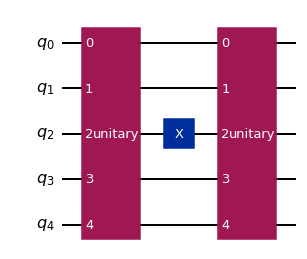

In [9]:
qr1 = QuantumRegister(5, 'q')
circ1 = QuantumCircuit(qr1)

# U some x gates and then Udagg; for example
circ1.append(scrOp, [qr1[i] for i in range(5)])
circ1.x(2)
circ1.append(udagg, [qr1[i] for i in range(5)])
circ1.draw("mpl", style="iqx")

You see already that we're effectively computing $U O U^{\dagger}$, directly in our quantum circuit. Moreover, you can note then that the initial operator $O$ is $O(t=0) = \sigma_{x}^{(2)}$.

Now, these unitaries are generated via a random combination of single- and multi- qubit gates. See [this paper](https://arxiv.org/abs/2101.08870) for specific details on the rotations employed. 

You may start to question the reproducibility of any results generated by this method, since unitaries are random and thus, "their own thing entirely". And you'd be correct had we not calculated the unitaries normalized "block decomposition method" (BDM) value. Again, see [this website](http://complexitycalculator.com/) for more details. 


Essentially, the _BDM score_ as we will refer to it from now on is a uniquely identifying number which tells us information about any randomly generated unitary. 

If a unitary's BDM is close to $0$, then most likely you're dealing with a unitary which is composed of the same gate applied to all qubits, or maybe even a unitary which is only the identity for example!

If on the other side, your unitary has a BDM of close to $1$, you're in luck since this unitary is as close to perfect randomness as possible. And remember, the more random the unitary, the "more entanglement" it will produce!

The above matrix's BDM is: (not too bad! BDM of >0.5 are really good!)

In [10]:
print("BDM for SU: {v1}\n".format(v1=bdmscore))

BDM for SU: 0.6518071427695802



## Part 2: "the quantum butterfly effect"

Finding out if scrambling is possible is our goal. One way to quantitatively say whether or not scrambling is present in our circuit shown by building so-called out-of-time-correlation (OTOC) functions. The OTOC looks at two sites in our quantum circuit and asks how correlated is the information in each site.

This is nothing more than asking wheter or not two operators in two distinct sites commute or not. Easy!

These OTOC functions are well known to decay quickly if a rapid scrambling of information happened in one of the sites it was looking at. We will look at one such situation in a moment. 

Below you see a circuit designed to measure such correlation functions. There you see our unitaries applied as well as an operator in the middle of them. (That $X$ gate)

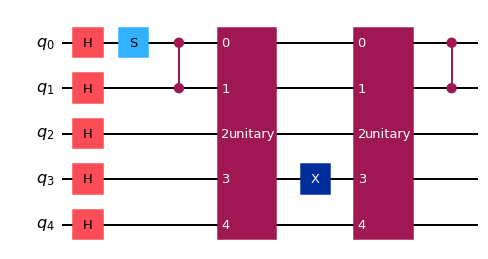

In [20]:
butterflycircuit, score = ButterflyCircuit(5,1,3, notRef=True)
butterflycircuit.draw("mpl", style="iqx")

In [22]:
print("U's characteristic BDM score turned out to be: {}\n".format(score))

U's characteristic BDM score turned out to be: 0.7834185414752937



All we have to do now is measure the OTOC as we vary some parameter. The time-dependency of the OTOC is usually resolved to be the cycles our scrambling unitaries contain, i.e. their circuit length. If they are really short in terms of the number of equivalent base gates they apply, then we can't really say much about the OTOC's evolution. 

Additionally, and to further resolve the statistics we may even vary the position of the $X$ gate in the middle and see how that changes things. Since remember, the unitaries are random, there's no telling which position the $X$ should have in order to increase the OTOC's sensibility. 

Let's run the circuit a number of times and collect some results then!

In a moment, you will effectively see the OTOC(t)'s time-dependence

Circuit depth, statistical repetitions and the number of qubits in our noisy channel contribute to the time it takes for the OTOC to evaluate.

Generally it should take from 1-30 minutes in order to get meaningful (and publishable) results.

The output plot will pop up whenever the computation is done! (:

(5, 20)


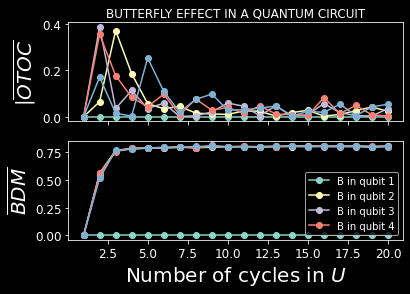

In [23]:
with ThreadPoolExecutor(4) as ex:
    print("In a moment, you will effectively see the OTOC(t)'s time-dependence\n")
    print("Circuit depth, statistical repetitions and the number of qubits in our noisy channel contribute to the time it takes for the OTOC to evaluate.\n")
    print("Generally it should take from 1-30 minutes in order to get meaningful (and publishable) results.\n")
    print("The output plot will pop up whenever the computation is done! (:\n")
    ex.map(avgOTOC(20,30,5, True, True))

# Discussion and outlook
What you see above is the absolute value of the correlation function decaying as a function of unitary cycles. We see this sharp decay in as early as $5$ repetitions (that means 5 two-qubit stages). Each color represents where the $X$ gate originally was located in our circuit. Of note is that BDM saturates as the OTOC peaks, essentially indicating that BDM alone could in fact serve as an alternative, more fundamental measure for scrambling. 

_We evolved this $X$ gate (our initial perturbation) and demonstrated the OTOC's decay in Qiskit_

The above shouldn't be taken lightly**, as we have effectively caught up with the top research institutes in the world in terms of finnesse and qualitative understanding - all while using IBM's open source API.


Bringing the state-of-the-art closer to the quantum enthusiast should be part of everyone's agenda; we did our part in demonstrating novel quantum phenomena in an open manner. 

There is still much to be done, for starters, the OTOC's decay isn't a perfect indicator of scrambling in the system. It is only when we combine its evident decay **with** the teleportation protocol as verification that our methods gain any weight, since we can actually guarantee that the unitary used generates scrambling. 

Additionally, further quantum-information-theoretic measures could be implemented to the procedure, of particular interest to us are measures of mutual information among partitions within the quantum system. This effectively would tell us how entanglement propagates in the quantum circuit. Which in turns would yield interest propositions for how information thrown into a wormhole may be decoded at the other end; effectively realizing a quantum traversable wormhole.  

Moreover, the implementation itself could use work. However, we did our best such that our code could be easily ported as, say, Qiskit's _EntanglementDynamics_ class one day.



# References:

Please see report for a full bibliographical list.